# Installing requirements, imports, loading everything

In [1]:
!pip install torchsummary
!pip install matplotlib --upgrade
!pip install scipy
!pip install foolbox

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import CIFAR10, FashionMNIST
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from torch import nn
from torchvision import transforms
from tqdm import tqdm
import pickle
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Loading datasets

In [3]:
C, H, W = [1, 32, 32]
num_classes = 10
tfms = transforms.Compose([
    transforms.Grayscale(C),
    transforms.ToTensor(),
    transforms.Resize([H, W]),
])
train_dataset = torchvision.datasets.MNIST(root='datasets/MNIST', train=True, transform=tfms, download=True)
test_dataset = torchvision.datasets.MNIST(root='datasets/MNIST', train=False, transform=tfms, download=True)
idx_to_class = {value:key for key, value in train_dataset.class_to_idx.items()}
class_to_idx = {key:value for key, value in train_dataset.class_to_idx.items()}

## Helper functions

C:\Users\ishaa\AppData\Local\Temp\ipykernel_18016\1912746585.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


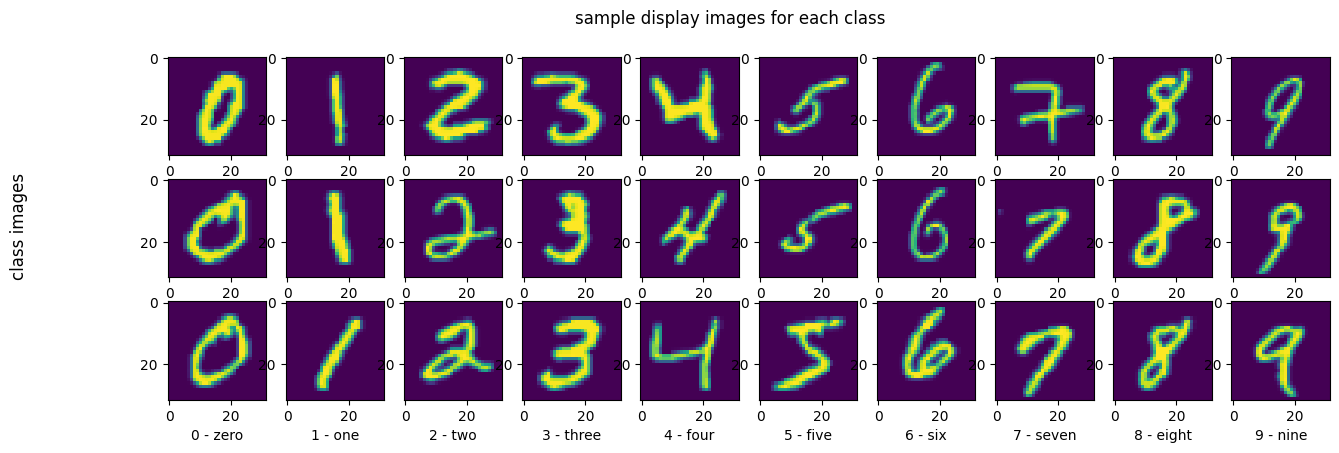

In [4]:
def display_imgs(dataset, num_images_per_class, title='', supylabel='class images'):
  fig, axs = plt.subplots(nrows=num_images_per_class, ncols=num_classes, figsize=[1.5*num_classes, 1.5*num_images_per_class])
  fig.supylabel(supylabel)
  fig.suptitle(title)
  for class_idx in range(num_classes):
    axs[num_images_per_class-1][class_idx].set_xlabel(idx_to_class[class_idx])
    count = num_images_per_class
    for image, label in dataset:
      if label == class_idx:
        count -= 1
        axs[count][class_idx].imshow(transforms.ToPILImage()(image))
      if count == 0:
        break
  fig.show()
  
display_imgs(train_dataset, 3, title='sample display images for each class')

In [5]:
def bn_track(model):
  for m in model.modules():
      for child in m.children():
          if type(child) == nn.BatchNorm2d:
              print(child.track_running_stats)
              print(child.running_mean)
              print(child.running_var)

def bn_define(model):
  for m in model.modules():
    for child in m.children():
      if type(child) == nn.BatchNorm2d: 
        child.track_running_stats = True
        child.running_mean = torch.zeros_like(child.running_mean)
        child.running_var = torch.ones_like(child.running_var)

def bn_compute(model, loader):
  bn_define(model)
  model.train()
  model = model.to(device)
  for images, labels in tqdm(loader):
    images, labels = images.to(device), labels.to(device)
    preds = model(images).argmax(dim=1)

def get_loss(model, loader, criterion):
  model.eval()
  losses = []
  sizes = []
  with torch.no_grad():
    for images, labels in tqdm(loader):
      images, labels = images.to(device), labels.to(device)
      scores = model(images)
      loss = criterion(scores, labels)
      losses.append(loss.item())
      sizes.append(images.shape[0])
  model.train()
  losses, sizes = np.array(losses), np.array(sizes)
  return sum(losses * sizes) / sum(sizes)

def get_accuracy(model, loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in tqdm(loader):
      images, labels = images.to(device), labels.to(device)
      scores = model(images)
      preds = scores.argmax(dim=1)
      correct += sum(preds == labels)
      total += sum(labels == labels)
  model.train()
  return correct / total

## Model classes

### Victim model (the classifier being attacked)

In [6]:
class Victim(nn.Module):
  def __init__(self, H, W, num_classes):
    super().__init__()

    self.features = nn.Sequential(
        nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        ),


        nn.AdaptiveAvgPool2d((H//32, W//32)),
        nn.Flatten(),
    )

    self.classifier = nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(True),
        nn.Linear(256, 128),
        nn.ReLU(True),
        nn.Linear(128, num_classes),
    )
    self._initialize_weights()
  
  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x
  
  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

victim_kwargs = {
    'H': H,
    'W': W,
    'num_classes': num_classes,
}


victim = Victim(H, W, num_classes).to(device)
bn_define(victim)
summary(victim, (C, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]              80
       BatchNorm2d-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
         AvgPool2d-4            [-1, 8, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           1,168
       BatchNorm2d-6           [-1, 16, 16, 16]              32
              ReLU-7           [-1, 16, 16, 16]               0
         AvgPool2d-8             [-1, 16, 8, 8]               0
            Conv2d-9             [-1, 32, 8, 8]           4,640
      BatchNorm2d-10             [-1, 32, 8, 8]              64
             ReLU-11             [-1, 32, 8, 8]               0
        AvgPool2d-12             [-1, 32, 4, 4]               0
           Conv2d-13             [-1, 64, 4, 4]          18,496
      BatchNorm2d-14             [-1, 6

### Decoder model (implementation of the paper)

In [7]:
# reference code snippet modified here - https://gist.github.com/anderzzz/1adfa12a409e6367f41fa60c8c2d5bb7
class DecoderVGG(nn.Module):
    '''Decoder of code based on the architecture of VGG-16 with batch normalization.
    Args:
        encoder: The encoder instance of `EncoderVGG` that is to be inverted into a decoder
    '''
    def __init__(self):
        super(DecoderVGG, self).__init__()

        # define the encoder portion which is the same as the victim model...
        encoder = Victim(H, W, num_classes).features
        self.encoder = encoder


        # define the inverse of the encoder
        self.decoder_stack = self._invert_(encoder[0])
        self.decoder = nn.Sequential(*self.decoder_stack)


    def decode(self, fl, fs):
      embeddings = torch.cat(tensors=(fl, fs), dim=1)
      x_hat = self.decoder(embeddings)
      return x_hat
    

    def forward(self, x, label_embeddings):
      semantic_embeddings = self.encoder(x)
      # not sure whether to use concatenation or addition here. some details absent or not clearly explained in the paper are the cause.
      embeddings = torch.cat(tensors=(label_embeddings, semantic_embeddings), dim=1)
      # embeddings = label_embeddings + semantic_embeddings 
      x_hat = self.decoder(embeddings)
      return x_hat


    def _invert_(self, encoder):
        '''Invert the encoder in order to create the decoder as a (more or less) mirror image of the encoder
        The decoder is comprised of two principal types: the 2D transpose convolution and the 2D unpooling. The 2D transpose
        convolution is followed by batch normalization and activation. Therefore as the module list of the encoder
        is iterated over in reverse, a convolution in encoder is turned into transposed convolution plus normalization
        and activation, and a maxpooling in encoder is turned into unpooling.
        Args:
            encoder (ModuleList): the encoder
        Returns:
            decoder (ModuleList): the decoder obtained by "inversion" of encoder
        '''
        # modules_transpose = [nn.Linear(128, 64), nn.BatchNorm2d(64), nn.ReLU(), nn.Unflatten(1, (64, 1, 1)), nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=4, padding=0)]
        modules_transpose = [nn.Linear(128, 64), nn.ReLU(), nn.Unflatten(1, (64, 1, 1)), nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=4, padding=0)]
        unpool_channel_list = [8, 16, 32]
        for module in reversed(encoder):

            if isinstance(module, nn.Conv2d):
                kwargs = {'in_channels' : module.out_channels, 'out_channels' : module.in_channels,
                          'kernel_size' : module.kernel_size, 'stride' : module.stride,
                          'padding' : module.padding}
                module_transpose = nn.ConvTranspose2d(**kwargs)
                module_norm = nn.BatchNorm2d(module.in_channels)
                module_act = nn.ReLU(inplace=True)
                modules_transpose += [module_transpose, module_norm, module_act]

            elif isinstance(module, nn.AvgPool2d):
                channels = unpool_channel_list.pop()
                kwargs = {'in_channels' : channels, 'out_channels' : channels,
                          'kernel_size' : module.kernel_size, 'stride' : module.stride,
                          'padding' : module.padding}
                module_transpose = nn.ConvTranspose2d(**kwargs)
                # module_transpose.weight = nn.Parameter(torch.ones_like(module_transpose.weight))
                # module_transpose.bias = nn.Parameter(torch.zeros_like(module_transpose.bias))
                # module_transpose.weight.requires_grad_(False)
                # module_transpose.bias.requires_grad_(False)
                modules_transpose += [module_transpose]

        # Discard the final normalization and activation, so final module is convolution with bias
        modules_transpose = modules_transpose[:-2]

        return nn.ModuleList(modules_transpose)

drr_kwargs = {
    
}

DRR = DecoderVGG(**drr_kwargs).to(device)
bn_define(DRR)
DRR(torch.cuda.FloatTensor(2, C, H, W), torch.cuda.FloatTensor(2, 64)).shape

torch.Size([2, 1, 32, 32])

## Loading datasets pt.2

In [8]:
num_epochs = 10
learning_rate = 3e-4
batch_size = 32
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Results
The results of the paper are all generated in this section. \
The model files are all loaded here itself. changes to this section may have unexpected and undesired outcomes.

In [9]:
import foolbox as fb

In [10]:
softmax = nn.Softmax(dim=1)
T = 2

def bn_compute_drr(victim, drr, loader):
  bn_define(drr)
  drr.train()
  drr = drr.to(device)
  for images, labels in tqdm(loader):
    images, labels = images.to(device), labels.to(device)
    xi = images
    generate_recons(xi, victim, drr)

def generate_recons(xi, v, drr):
    fl = softmax(v.features(xi) / T)
    fs = softmax(drr.encoder(xi) / T)
    xi_hat = drr.decode(fl, fs)
    return xi_hat

DRR_model_path = "new_saved/checkpoints/ruz-run5_batch_id-1860/drr_mnist.pt"
victim_model_path = "new_saved/checkpoints/ruz-run5_batch_id-1860/victim_mnist.pt"

DRR = DecoderVGG(**drr_kwargs)
DRR.load_state_dict(torch.load(DRR_model_path))
victim = Victim(**victim_kwargs)
victim.load_state_dict(torch.load(victim_model_path))
DRR, victim = DRR.to(device), victim.to(device)
bn_compute(victim, train_loader)
victim.eval()
bn_compute_drr(victim, DRR, train_loader)

for images, labels in train_loader: break
images, labels = images.to(device), labels.to(device)
xi = images
generate_recons(images, victim, DRR).shape

100%|██████████| 1875/1875 [00:15<00:00, 122.53it/s]


torch.Size([32, 1, 32, 32])

In [65]:
model = victim
fmodel = fb.PyTorchModel(model, bounds=(0, 1))

attack = fb.attacks.PGD()
epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]
for images, labels in test_loader: break
images, labels = images.to(device), labels.to(device)
_, advs, success = attack(fmodel, images, labels, epsilons=epsilons)

## Visual results
The effect of adversarial attack and reconstruction using our approach is discussed in this section.

In [76]:
attacks = [fb.attacks.L2PGD(), fb.attacks.LinfPGD(), fb.attacks.FGM(), fb.attacks.FGSM()]
epsilonss = [4, 0.15, 6, 0.15]

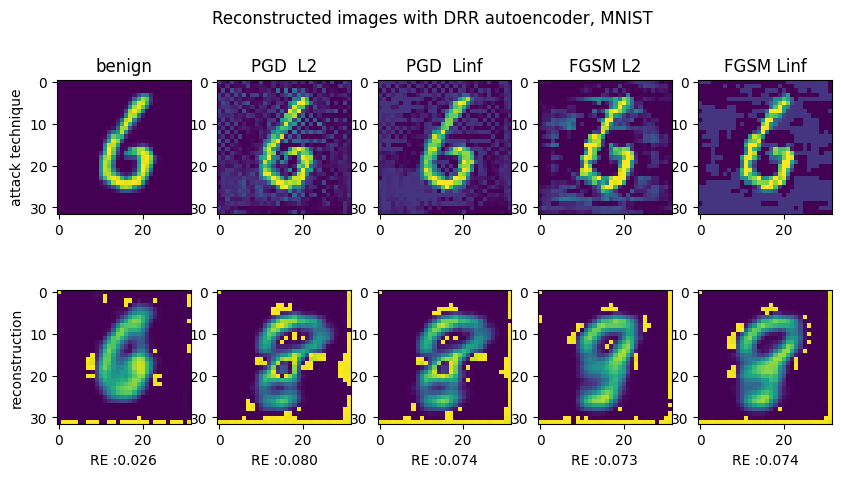

In [77]:
i = 50
image, label = test_dataset[i]
image = image.to(device)
image = torch.unsqueeze(image, dim=0)
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=[10, 5])
axs[0][0].set_ylabel('attack technique')
axs[1][0].set_ylabel('reconstruction')
axs[0][0].set_title('benign')
axs[0][1].set_title('PGD  L2')
axs[0][2].set_title('PGD  Linf')
axs[0][3].set_title('FGSM L2')
axs[0][4].set_title('FGSM Linf')
fig.suptitle(f'Reconstructed images with DRR autoencoder, MNIST')
model = victim.to(device)
fmodel = fb.PyTorchModel(model, bounds=(0, 1))
pil = transforms.ToPILImage()
error = nn.MSELoss()

# benign
image_hat = generate_recons(image, victim, DRR)
axs[0][0].imshow(pil(torch.squeeze(image)))
axs[1][0].imshow(pil(torch.squeeze(image_hat)))
axs[1][0].set_xlabel(f'RE :{error(image_hat, image):.3f}')

# attacked
for i, (attack, espilon) in enumerate(list(zip(attacks, epsilonss))):
    epsilons = [espilon]
    _, advs, success = attack(fmodel, image, torch.Tensor([label]).type(torch.int64).to(device), epsilons=epsilons)
    recon = generate_recons(advs[0], victim, DRR)
    axs[0][i+1].imshow(pil(torch.squeeze(advs[0])))
    axs[1][i+1].imshow(pil(torch.squeeze(recon)))
    axs[1][i+1].set_xlabel(f'RE :{error(advs[0], recon):.3f}')


plt.show()


## Boxplots
The tendency of the reconstruction error to be higher for attacked samples is shown.

In [78]:
import pandas as pd
columns = ['benign', 'PGD  L2', 'PGD  Linf', 'FGSM L2', 'FGSM Linf',]
o, p1, p2, f1, f2 = [], [], [], [], []
err = nn.MSELoss(reduction='none')

for images, labels in tqdm(test_loader):
    xi, yi = images.to(device), labels.to(device)
    xi_hat = generate_recons(xi, victim, DRR)
    errors = err(xi, xi_hat)
    errors = torch.mean(torch.mean(torch.squeeze(errors), dim=1), dim=1).tolist()
    o += errors

    for i, (attack, espilon, store) in enumerate(list(zip(attacks, epsilonss, [p1, p2, f1, f2]))):
        epsilons = [espilon]
        _, advs, success = attack(fmodel, xi, yi, epsilons=epsilons)
        xki_hat = generate_recons(advs[0], victim, DRR)
        errors = err(xki_hat, advs[0])
        errors = torch.mean(torch.mean(torch.squeeze(errors), dim=1), dim=1).tolist()
        store += errors

        
        


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


In [79]:
results = pd.DataFrame(
    columns=columns,
    data=np.array([o, p1, p2, f1, f2]).T
)

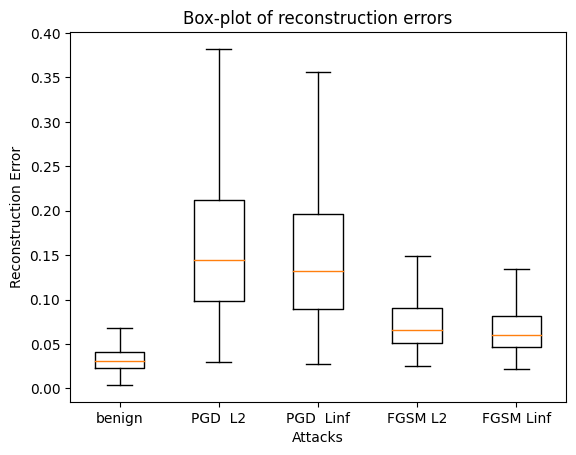

In [80]:
plt.boxplot(results.to_numpy(), notch=None,vert=None,patch_artist=None,widths=None, showfliers=False, flierprops=None)
plt.xticks(range(1, 1+len(columns)), columns)
plt.ylabel(f'Reconstruction Error')
plt.xlabel(f'Attacks')
plt.title(f'Box-plot of reconstruction errors')
plt.show()